In [1]:
%load_ext autoreload
%autoreload 2

from numcosmo_py import Ncm, Nc, GObject

from richness_mass_calib import create_richness_mass_calib
import numpy as np
import math
import sys
import os.path

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt

#Settings
Ncm.cfg_init()

%matplotlib inline
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy")



# DC2 data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

dt_halos = Table(DC2_halos_m200c[1].data)

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)



# lnR mean and std

def compute_res(rich_model):

    lnR_mean = np.array(
        [rich_model.get_mean_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    lnR_std = np.array(
        [rich_model.get_std_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    
    lnr_cut = np.array(
        [rich_model.get_cut(lnM[i], z[i]) for i in range(len(dt_halos))])

    abs_err = (lnR - lnR_mean) / lnR_std
    # Data cut
    sigma_cut = 5.0

    sigma_cut_array = np.abs(abs_err) < sigma_cut
    print(f"Cutting {sigma_cut}-sigma, {np.sum(np.logical_not(sigma_cut_array))}")

    lnR_mean = lnR_mean[sigma_cut_array]
    z_sigma_cut = z[sigma_cut_array]
    lnM_sigma_cut = lnM[sigma_cut_array]
    abs_err = abs_err[sigma_cut_array]
    lnR_ext = lnR[sigma_cut_array]
    lnr_cut = lnr_cut[sigma_cut_array] 
    
    return abs_err, lnR_mean, z_sigma_cut, lnM_sigma_cut, lnr_cut, lnR_ext 


In [2]:
fit_results_ascaso = []
fit_results_ext = []

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

z_0 = 0.0
z_1 = 0.05

nbins = int((max(z) - min(z)) / 0.05)

for i in range(61):
    
    dt_halos = Table(DC2_halos_m200c[1].data)
    catalog_cut = np.logical_and (dt_halos['redshift_true'] > z_0, dt_halos['redshift_true'] < z_1)
    dt_halos = dt_halos[catalog_cut]
    z_0 = z_0 + 0.05
    z_1 = z_1 + 0.05
    
    rmdata = create_richness_mass_calib(dt_halos)
    
    use_ascaso = False

    ascaso = Nc.ClusterMassAscaso()

    ascaso.param_set_by_name("mup0", 4.45393539397061)
    ascaso.param_set_by_name("mup1", 0.688627943224023)
    ascaso.param_set_by_name("mup2", 1.23735536845047)
    ascaso.param_set_by_name("sigmap0", 0.227197277810533)
    ascaso.param_set_by_name("sigmap1", -0.0514034833229222)
    ascaso.param_set_by_name("sigmap2", -0.125446104089159)
    ascaso.param_set_by_name("cut", 1e15)

    
    ascaso.param_set_ftype(0, Ncm.ParamType.FREE)
    ascaso.param_set_ftype(1, Ncm.ParamType.FREE)
    ascaso.param_set_ftype(2, Ncm.ParamType.FREE)
    ascaso.param_set_ftype(3, Ncm.ParamType.FREE)
    ascaso.param_set_ftype(4, Ncm.ParamType.FREE)
    ascaso.param_set_ftype(5, Ncm.ParamType.FREE)
    ascaso.param_set_ftype(6, Ncm.ParamType.FIXED)

    lnrich_ext = Nc.ClusterMassLnrichExt()
    lnrich_ext.param_set_by_name("mu", 4.60456407051582)
    lnrich_ext.param_set_by_name("muM1", 0.872079943089853)
    lnrich_ext.param_set_by_name("muZ1", 1.77432682440775)
    lnrich_ext.param_set_by_name("muM2", 0.0417736274804596)
    lnrich_ext.param_set_by_name("muZ2", -0.140721577418961)
    lnrich_ext.param_set_by_name("muMZ", 0.142254333837774)

    lnrich_ext.param_set_by_name("sigma0", 0.288099083637692)
    lnrich_ext.param_set_by_name("sigmaM1", 0.01665425603827)
    lnrich_ext.param_set_by_name("sigmaZ1", -0.0170544925340452)
    lnrich_ext.param_set_by_name("sigmaM2", 0.0151710348889877)
    lnrich_ext.param_set_by_name("sigmaZ2", 0.00841242091702829)
    lnrich_ext.param_set_by_name("sigmaMZ", 0.0375086602261856)

    lnrich_ext.param_set_by_name("cut", 1e15)
    lnrich_ext.param_set_by_name("cutM1", 0)
    lnrich_ext.param_set_by_name("cutZ1", 0)

    
    lnrich_ext.param_set_ftype(0, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(1, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(2, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(3, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(4, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(5, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(6, Ncm.ParamType.FREE)

    lnrich_ext.param_set_ftype(7, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(8, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(9, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(10, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(11, Ncm.ParamType.FREE)

    lnrich_ext.param_set_ftype(12, Ncm.ParamType.FIXED)
    lnrich_ext.param_set_ftype(13, Ncm.ParamType.FIXED)
    lnrich_ext.param_set_ftype(14, Ncm.ParamType.FIXED)

    mset_ascaso = Ncm.MSet()
    mset_ascaso.set(ascaso)

    mset_ext = Ncm.MSet()
    mset_ext.set(lnrich_ext)
    
    dset = Ncm.Dataset.new()
    dset.append_data(rmdata)

    lh = Ncm.Likelihood.new(dset)

    # mset_ascaso.param_set_all_ftype(Ncm.ParamType.FIXED)
    # mset_ext.param_set_all_ftype(Ncm.ParamType.FIXED)

    fit_ascaso = Ncm.Fit.factory(
        Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ascaso, Ncm.FitGradType.NUMDIFF_CENTRAL)

    fit_ext = Ncm.Fit.factory(
        Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ext, Ncm.FitGradType.NUMDIFF_CENTRAL)

    fit_ascaso.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
    fit_ext.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
    
    lnM = np.log(dt_halos["m200c"])  # ln(mass)
    z = dt_halos["redshift_true"]  # redshift
    lnR = np.log(dt_halos["richness"])  # ln(richness)
    
    res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnr_cut_ascaso, lnR_ascaso  = compute_res(ascaso)

    res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnr_cut_ext, lnR_ext  = compute_res(lnrich_ext)
    
    fit_results_ascaso.append((res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnr_cut_ascaso, lnR_ascaso))
    fit_results_ext.append((res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnr_cut_ext, lnR_ext))


#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#.................................................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0020800
#  iteration            [000401]
#  function evaluations [000403]
#  gradient evaluations [000000]
#  degrees of freedom   [000083]
#  m2lnL     =     65.1554411031216 (     65.155441 )
#  Fit parameters:
#     4.42862560673726     0.703317755168691    1.13465042593869     1.13193624311026    -0.0592505024653691   1.99200471216627    
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 0.806804806812281     
#  - relative improvement: 0.0122313119525055    
#  - m2lnL_0  :            65.9622459099339      
#

In [3]:
# Residuals

res_ascaso_z=[]
lnR_mean_ascaso_z=[]
z_sigma_cut_ascaso_z=[]
lnM_sigma_cut_ascaso_z=[]

for i, j, k, l, m, n in fit_results_ext:
    res_ascaso_z.append(i)
    lnR_mean_ascaso_z.append(j)
    z_sigma_cut_ascaso_z.append(k)
    lnM_sigma_cut_ascaso_z.append(l)
    
    
print(len(res_ascaso_z), len(lnR_mean_ascaso_z))


# for i, j, k, l, m, n in fit_results_ext:
#     fig = plt.figure(figsize=(14,7))
#     ax1 = fig.add_subplot(2,2,1)
#     ax2 = fig.add_subplot(2,2,2)

#     ax1.scatter(l, i, c="skyblue")
#     ax1.set_xlabel("$\ln M$")
#     ax1.set_ylabel("Resíduos: Extendida")

#     ax2.scatter(k, i, c="skyblue")
#     ax2.set_xlabel("$z$")
#     ax2.set_ylabel("Residuals Extendida")
    
#     ax3.scatter(k, i, c="skyblue")
#     ax3.set_xlabel("$z$")
#     ax3.set_ylabel("Residuals Extendida")


61 61


/tmp/ipykernel_705406/195716510.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(14,7))


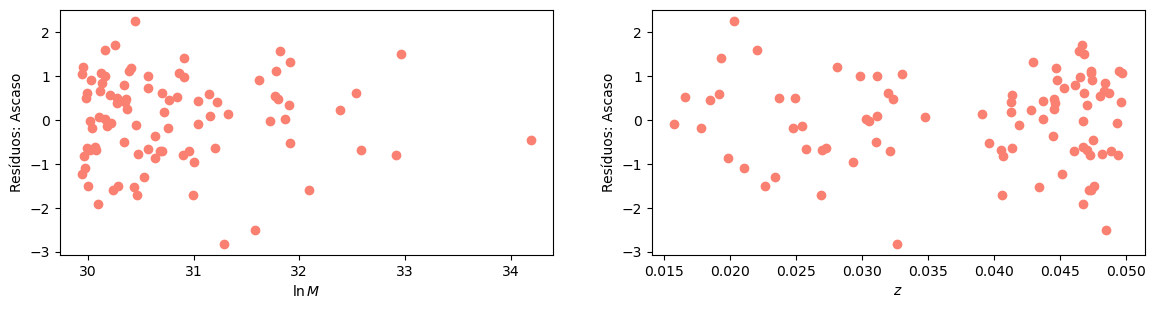

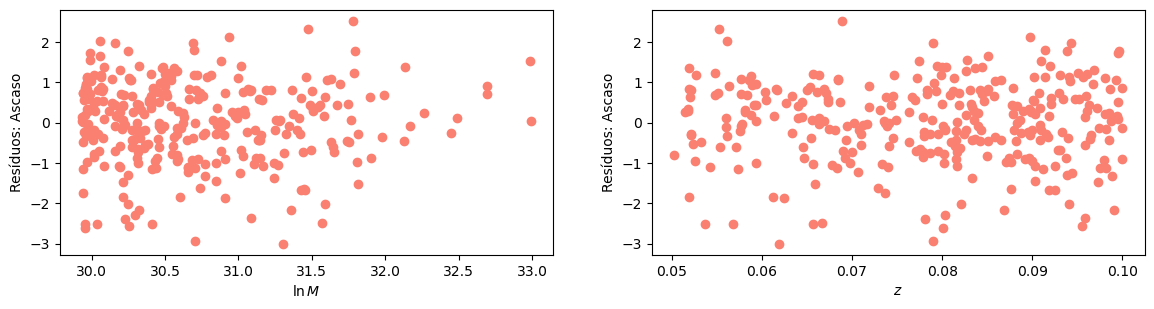

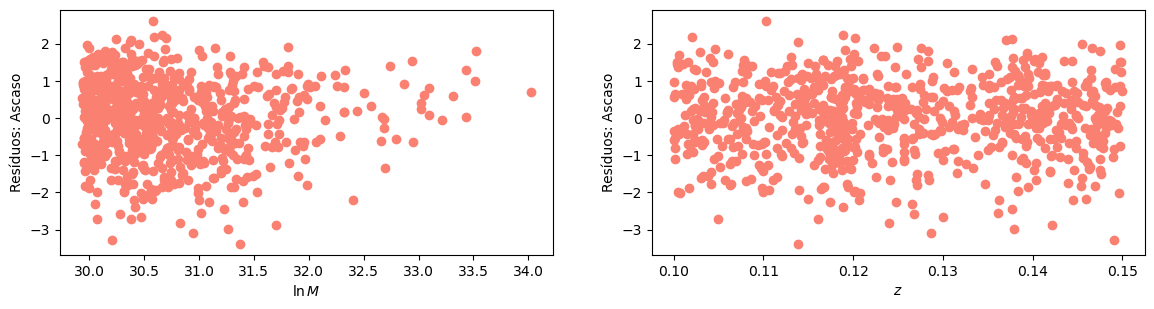

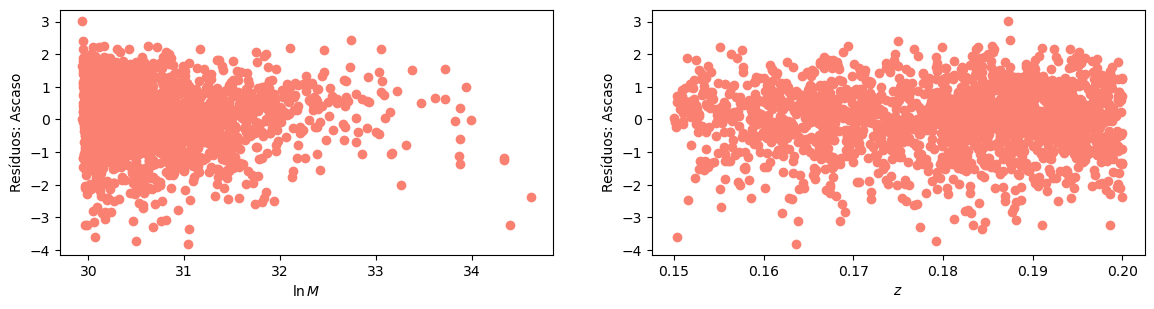

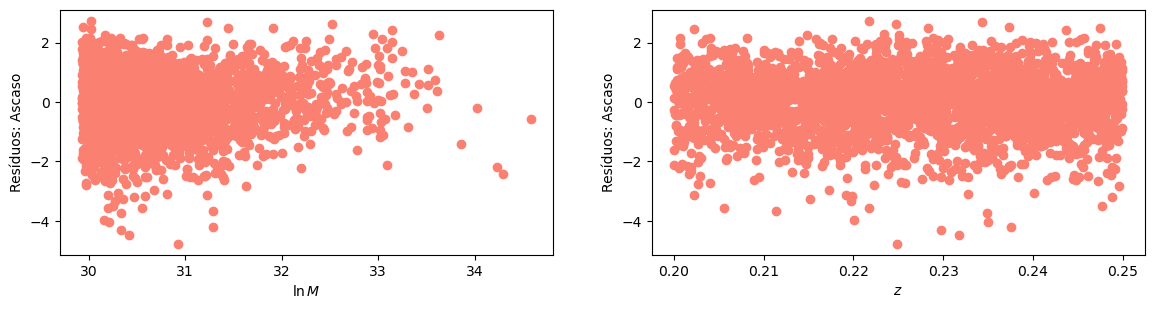

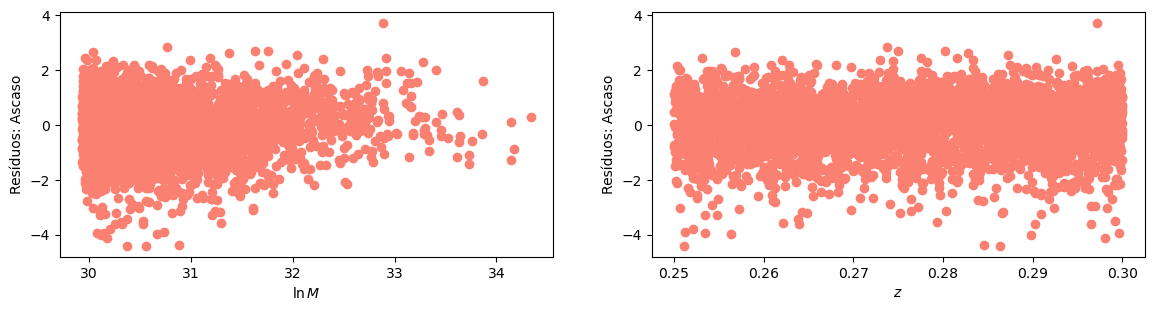

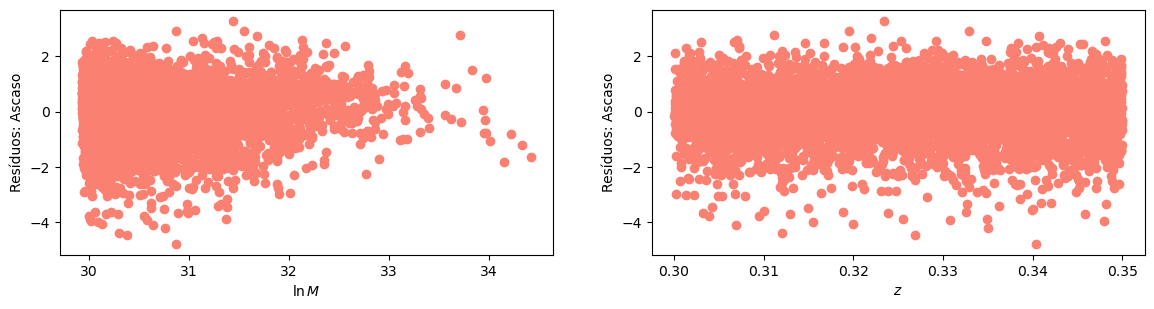

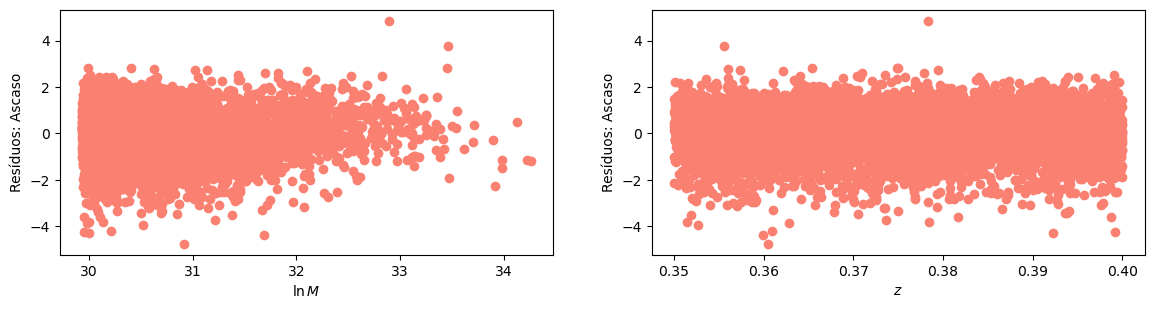

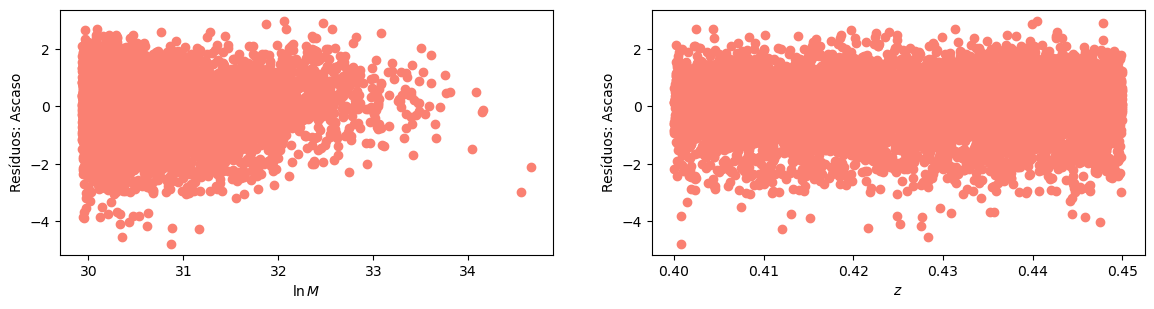

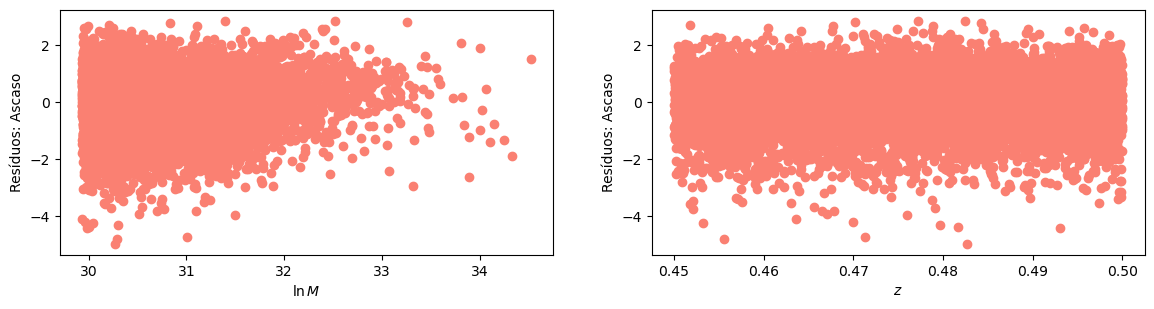

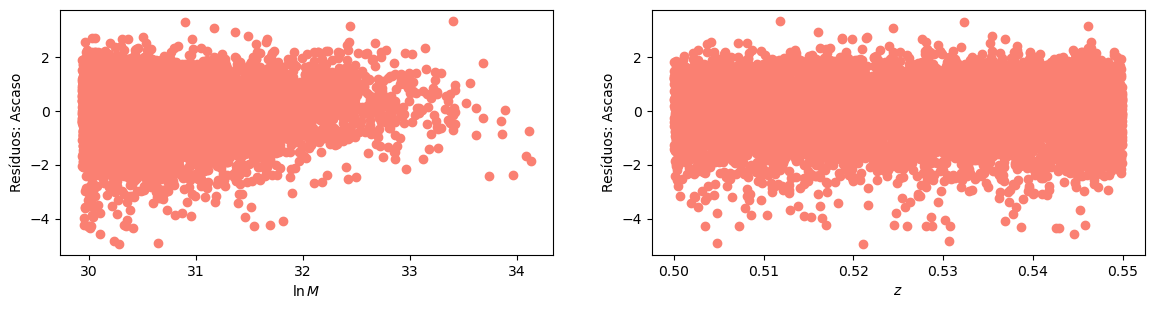

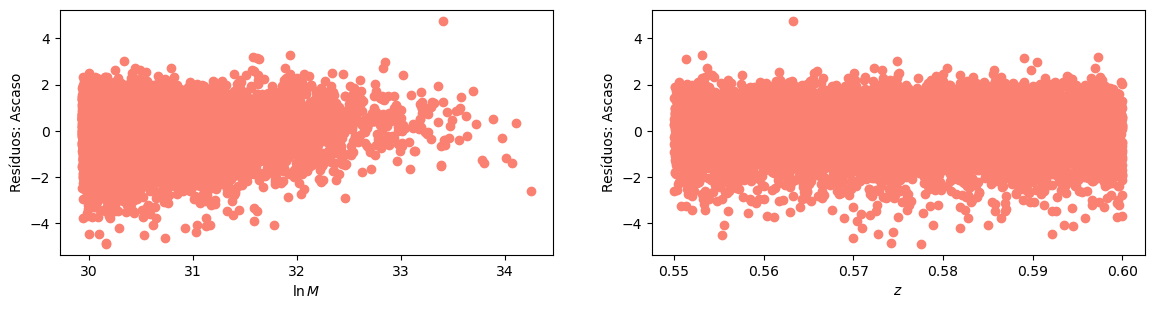

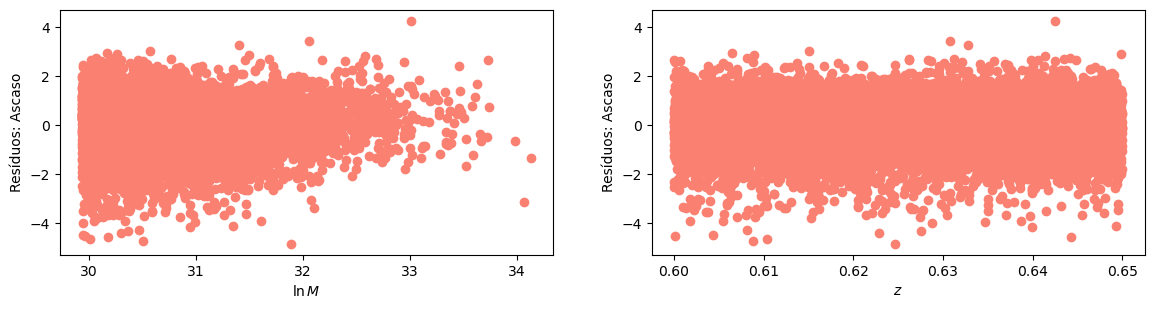

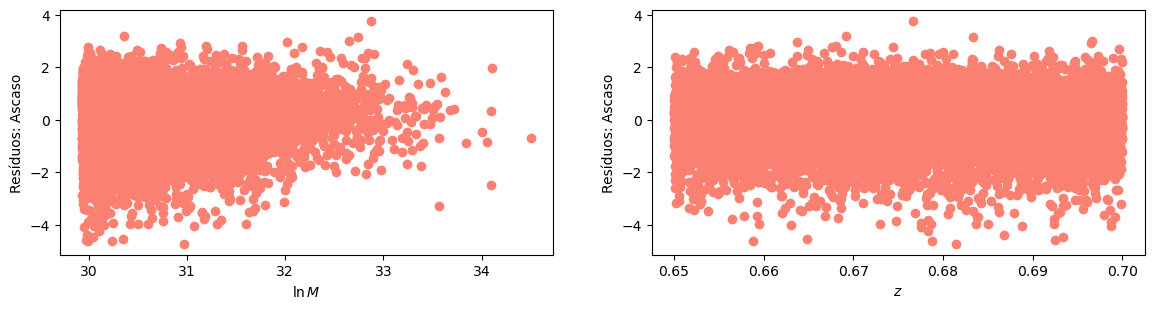

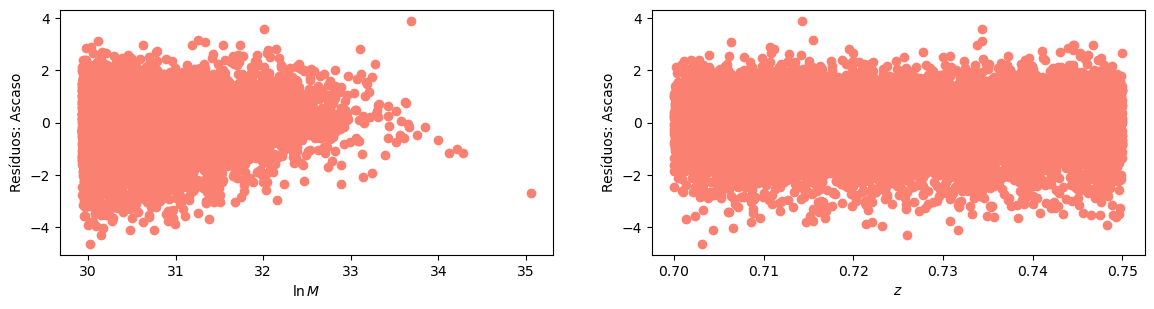

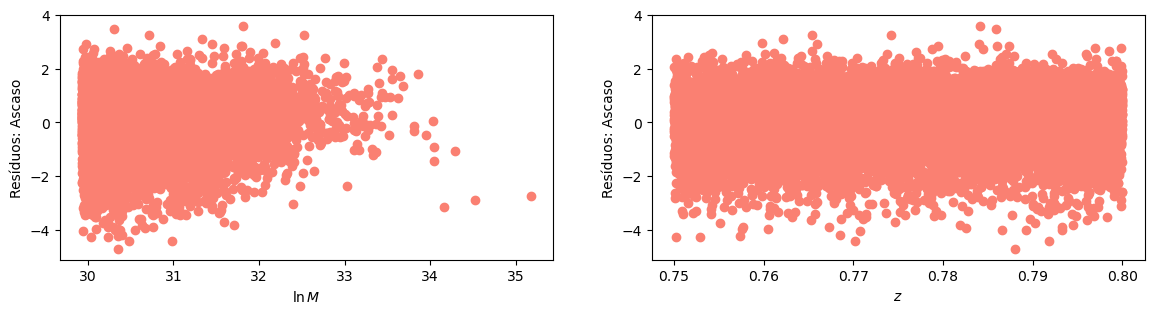

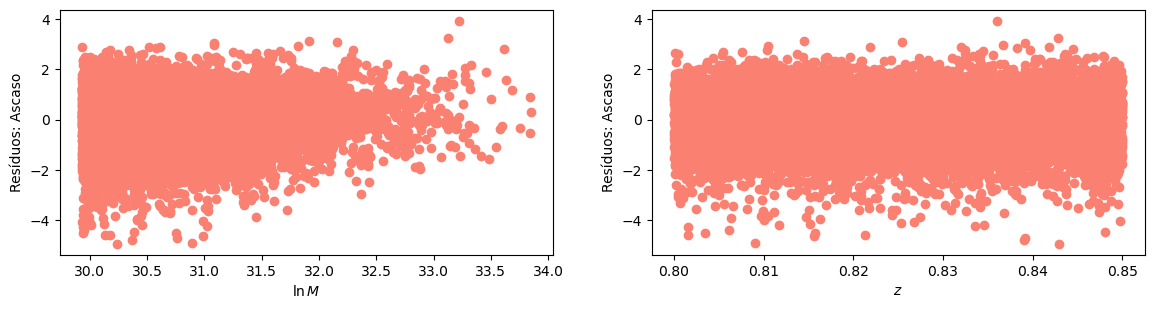

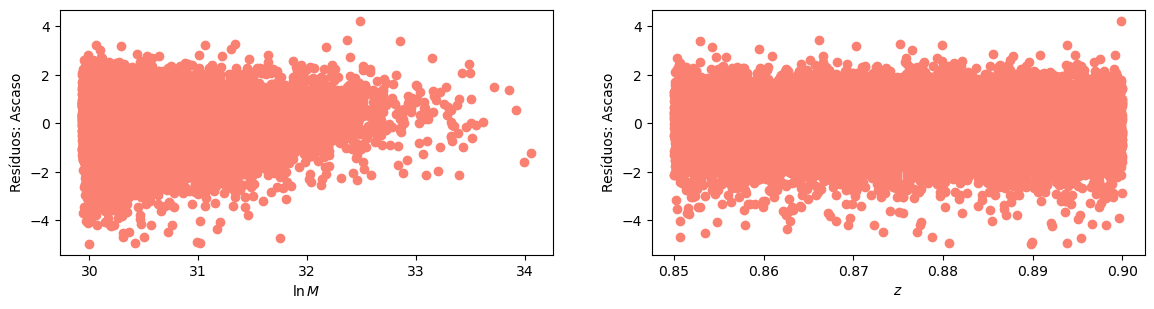

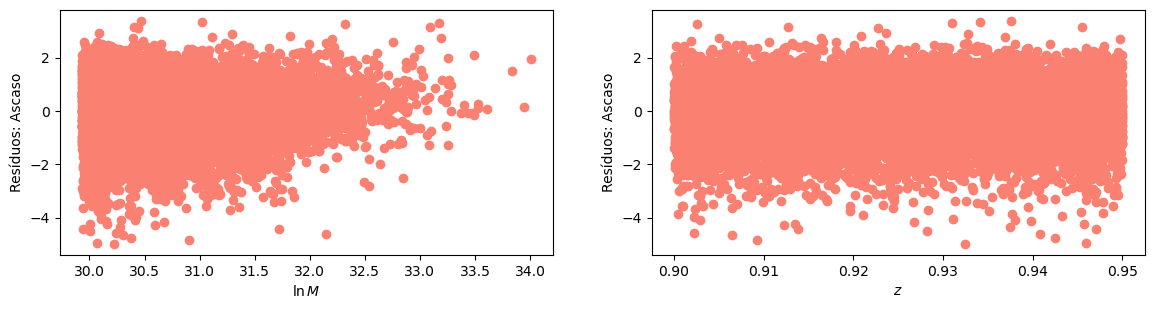

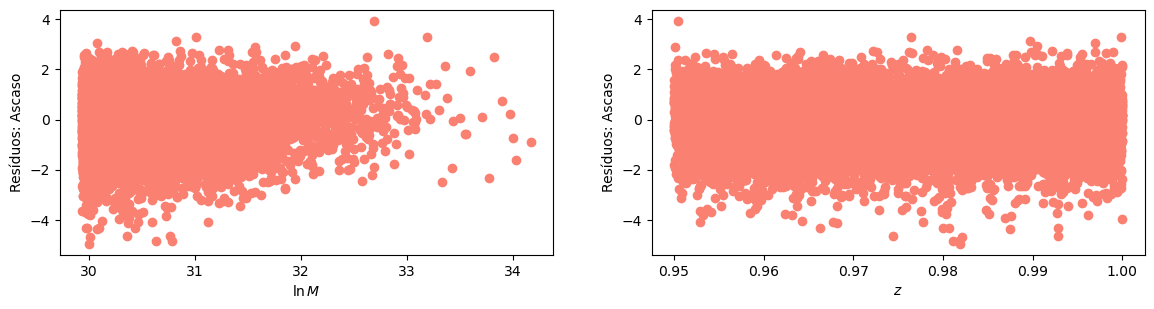

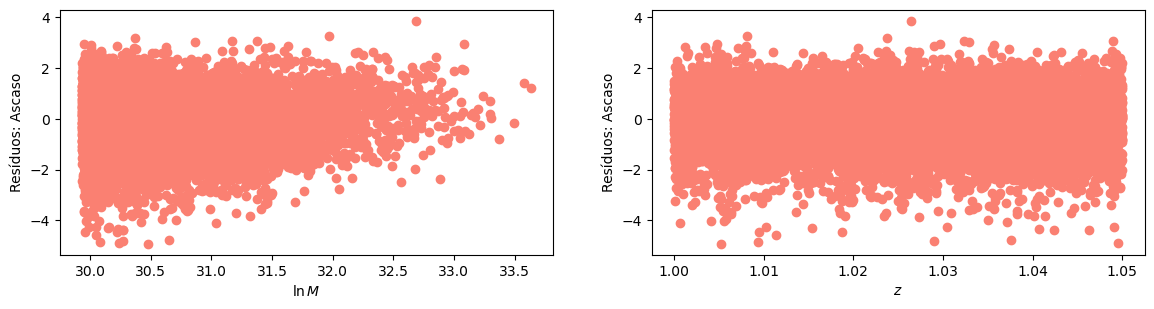

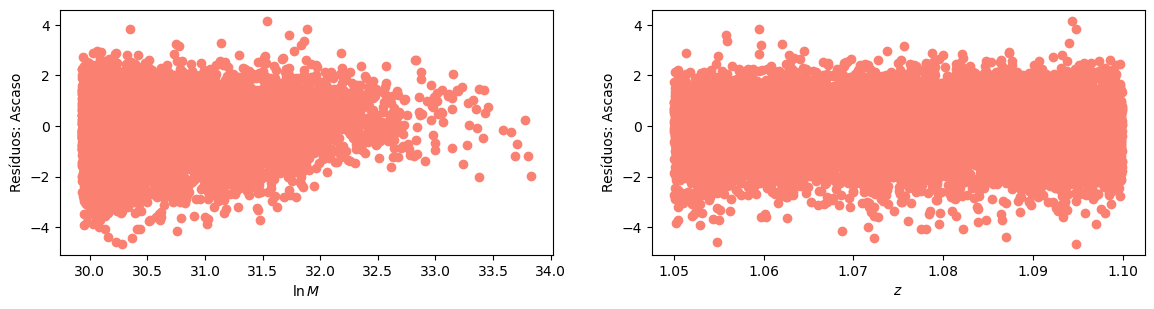

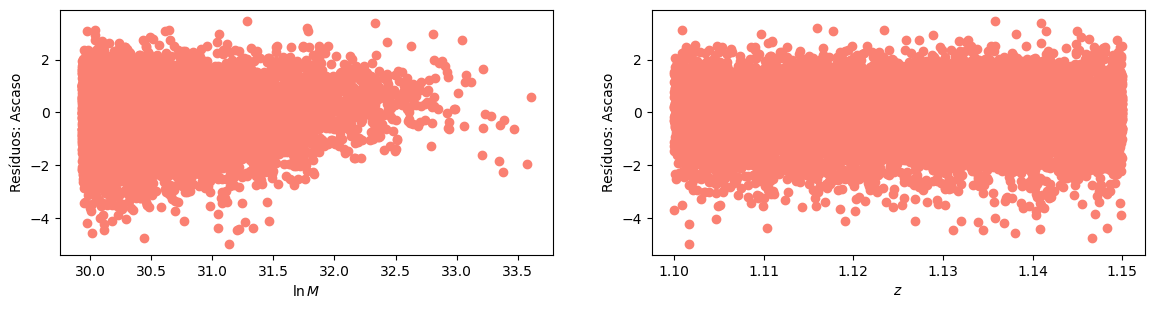

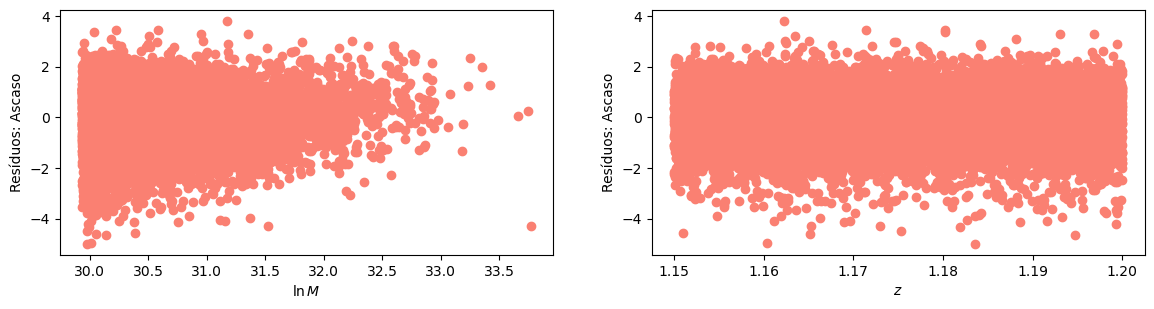

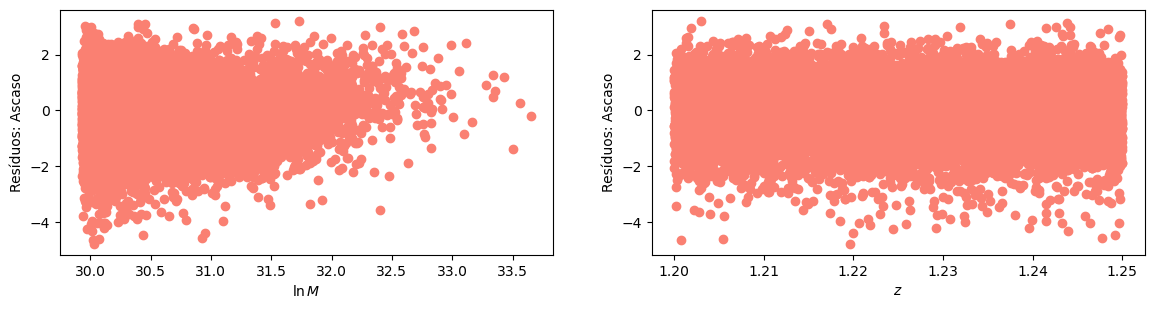

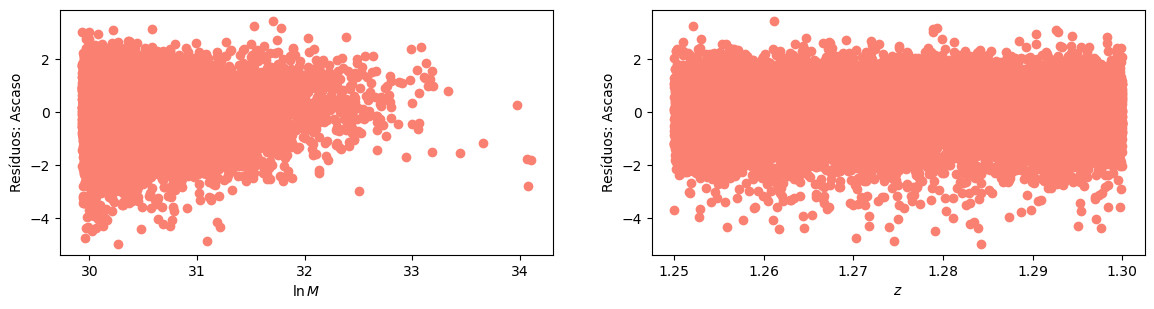

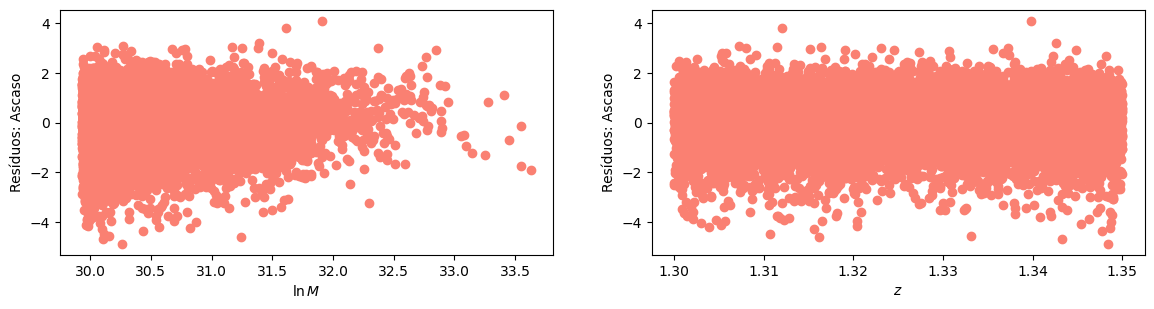

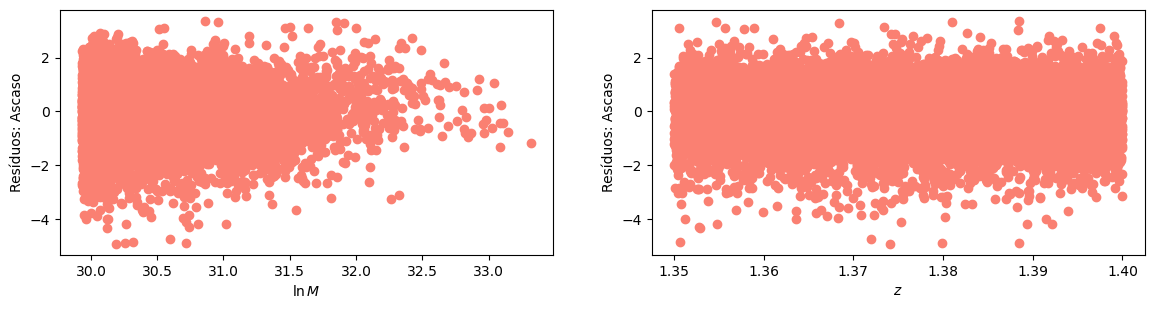

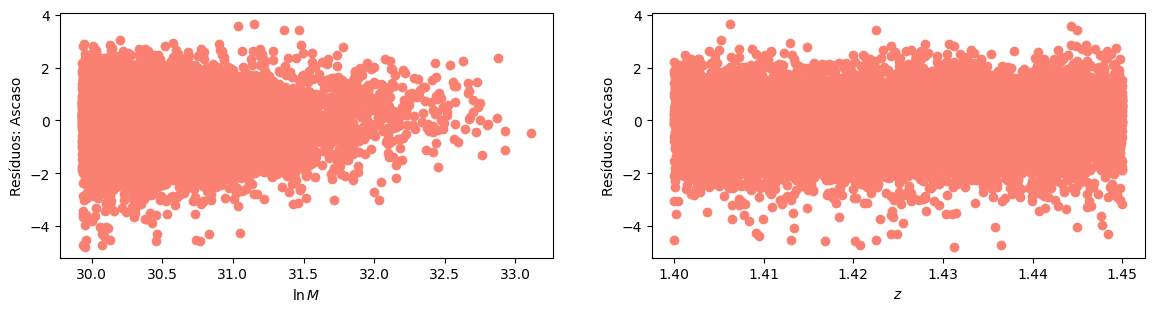

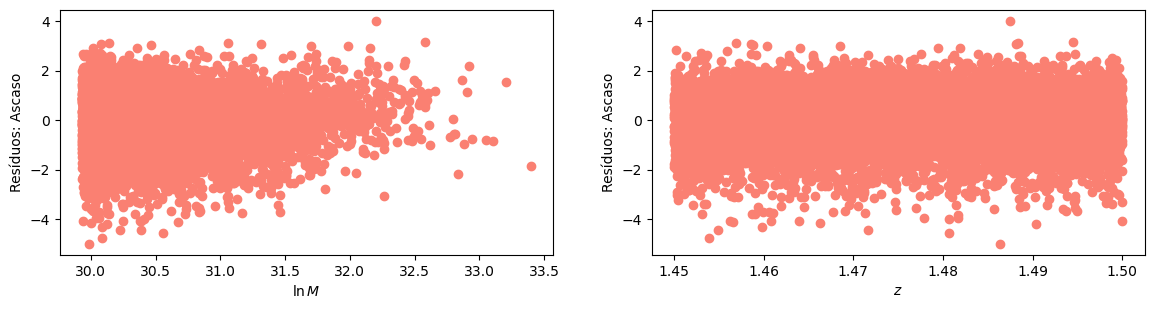

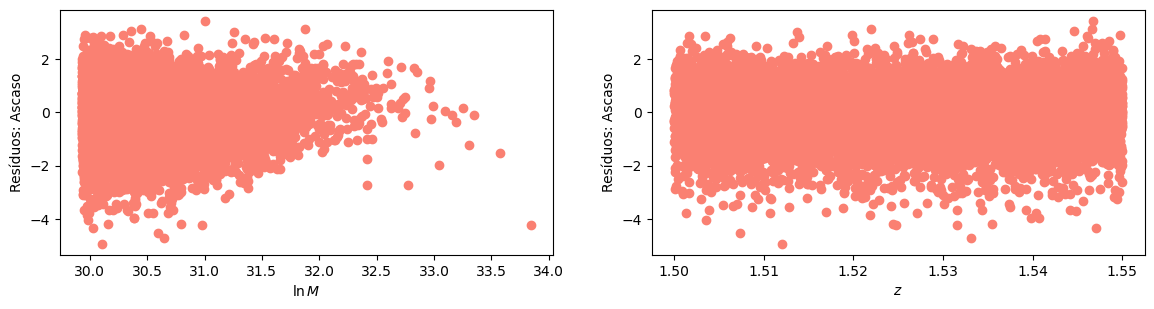

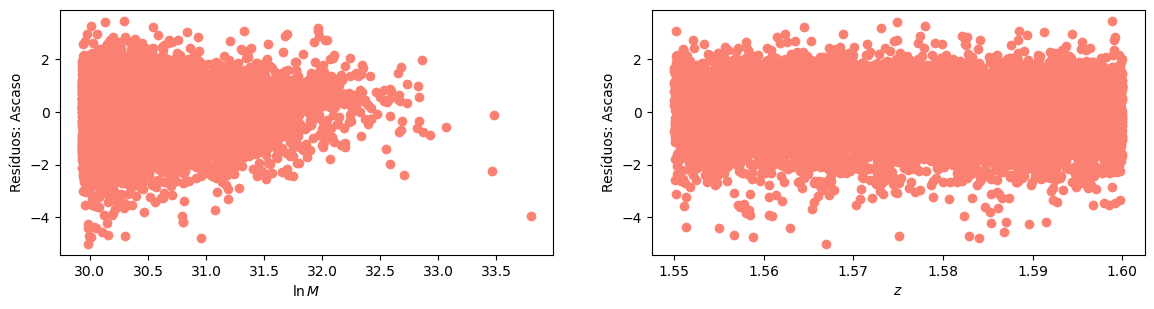

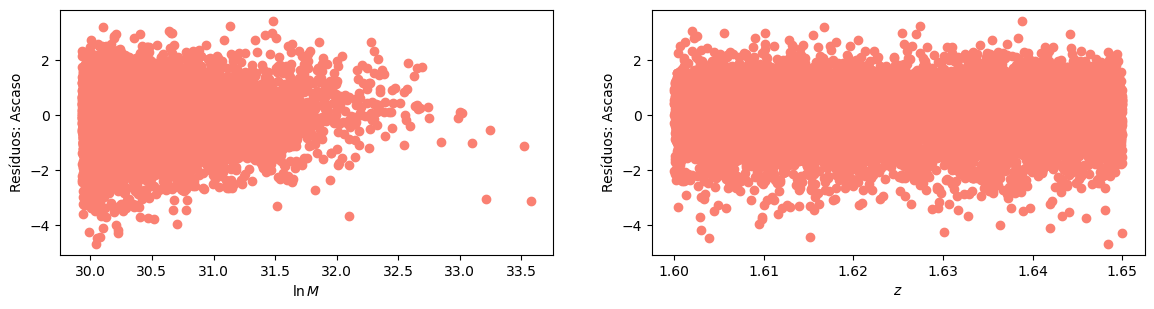

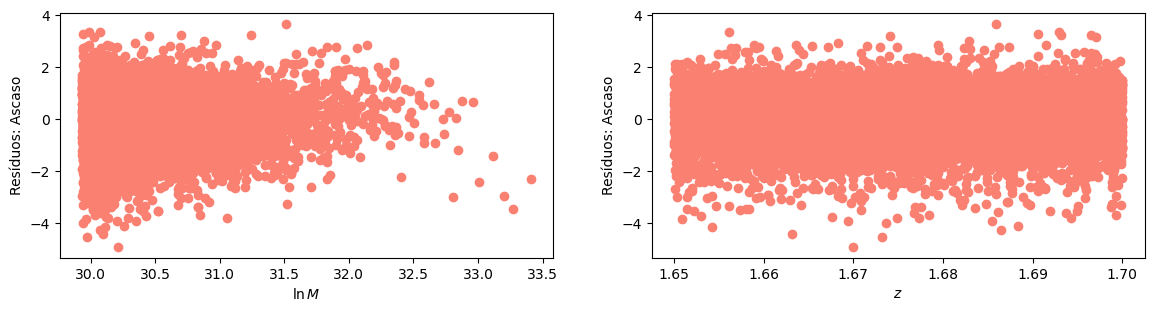

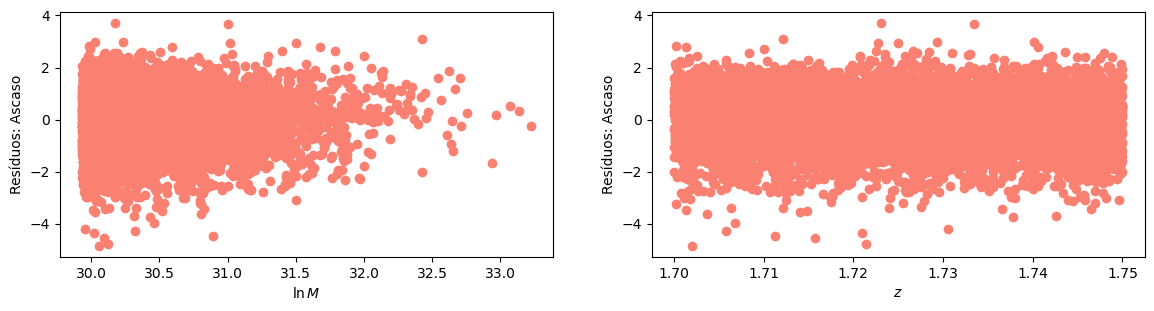

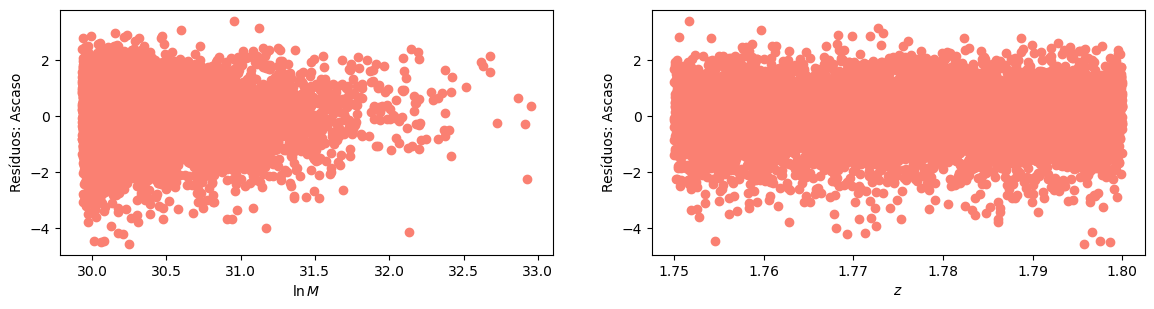

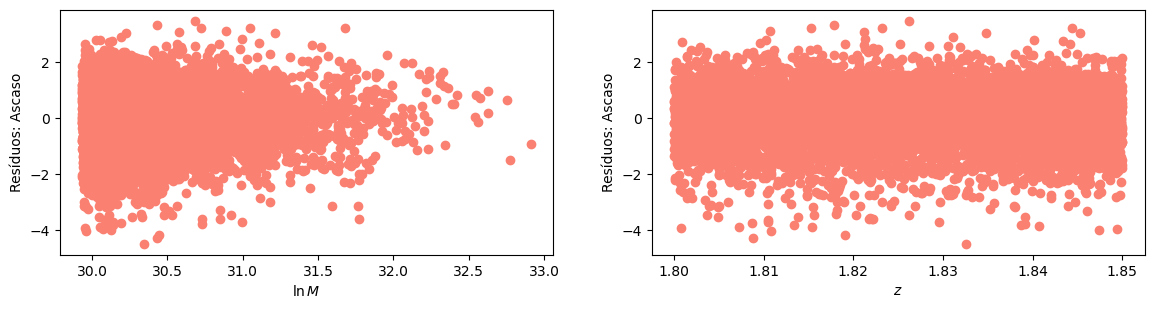

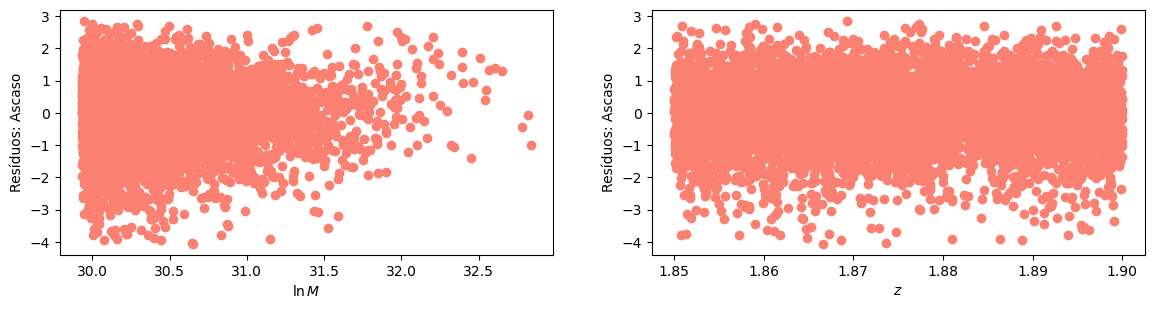

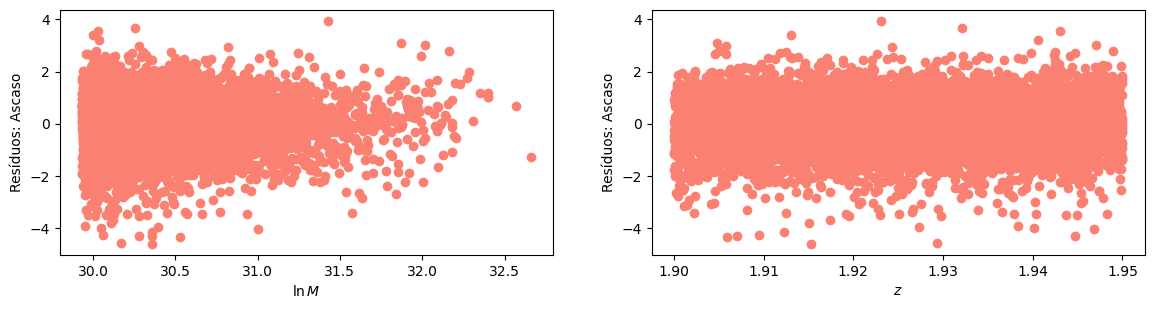

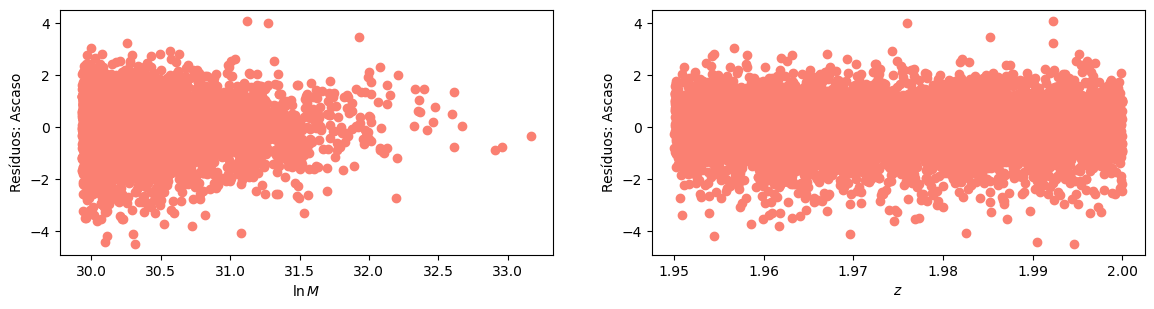

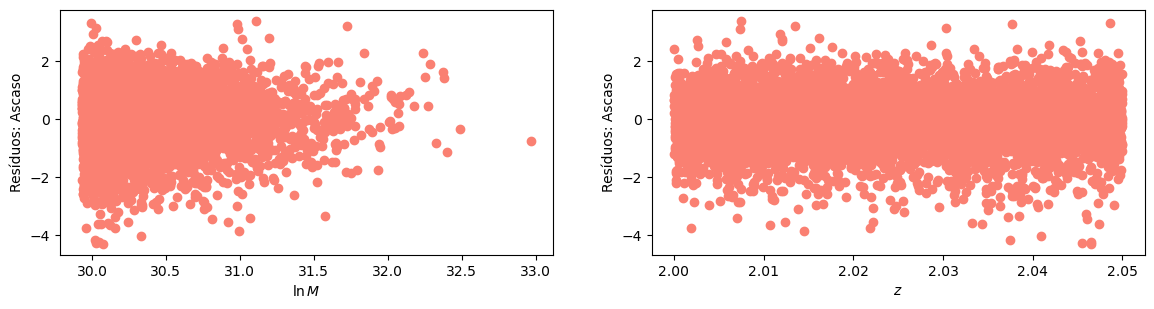

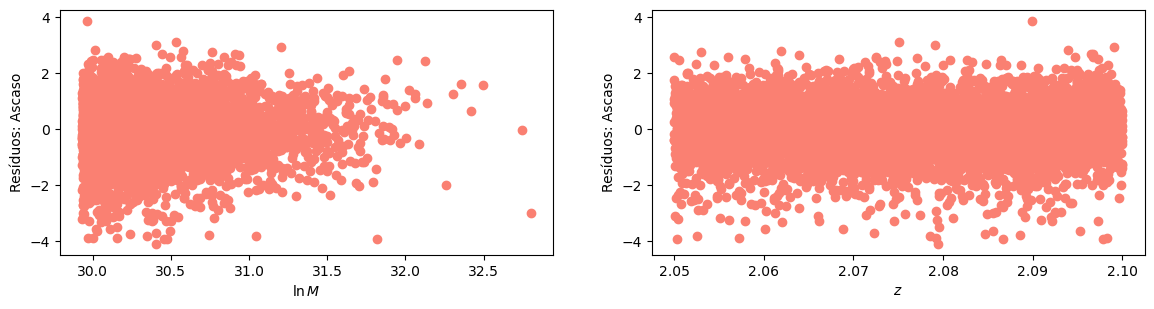

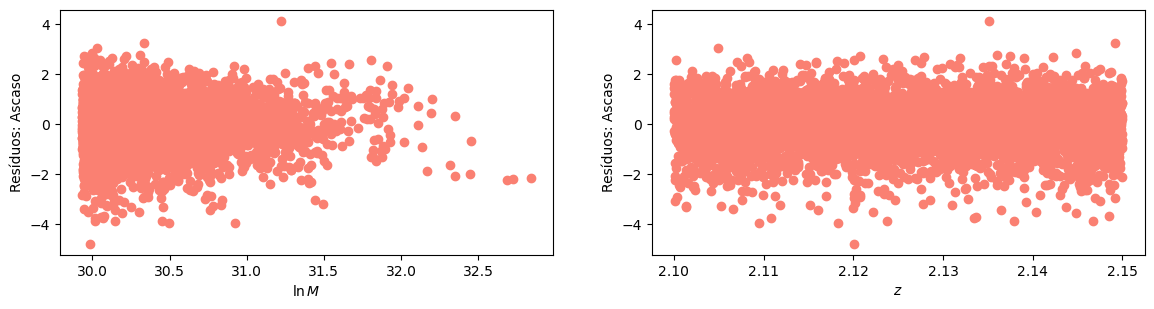

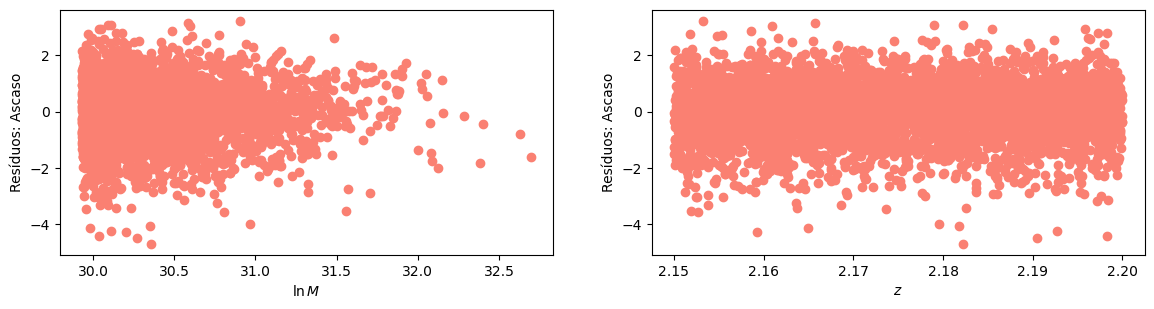

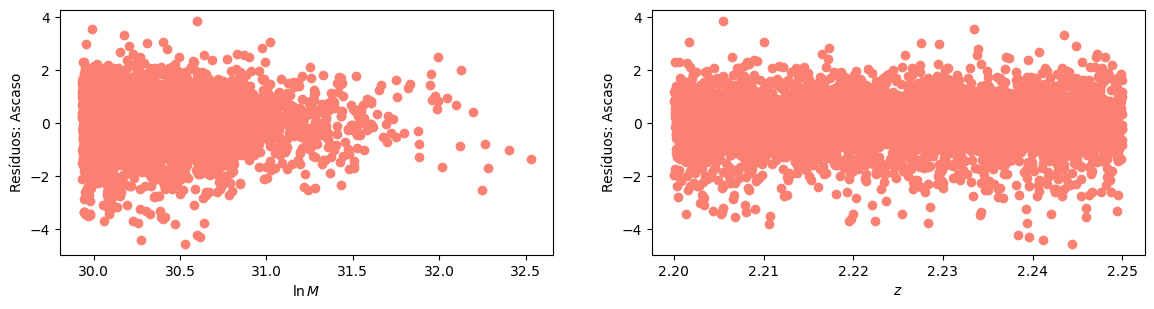

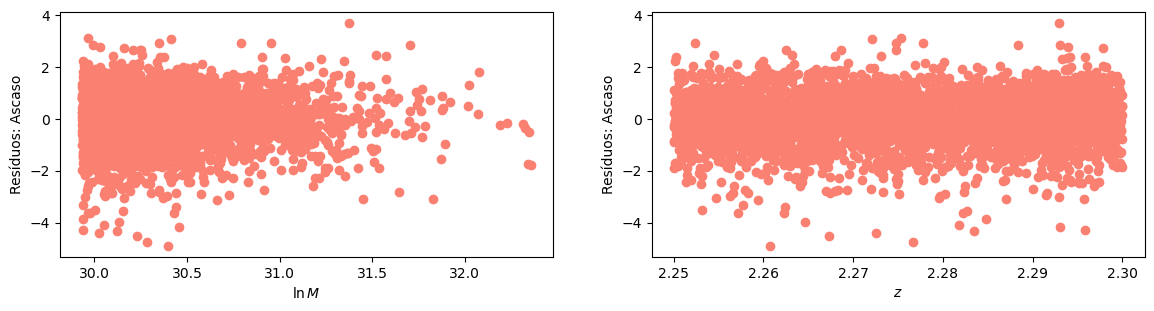

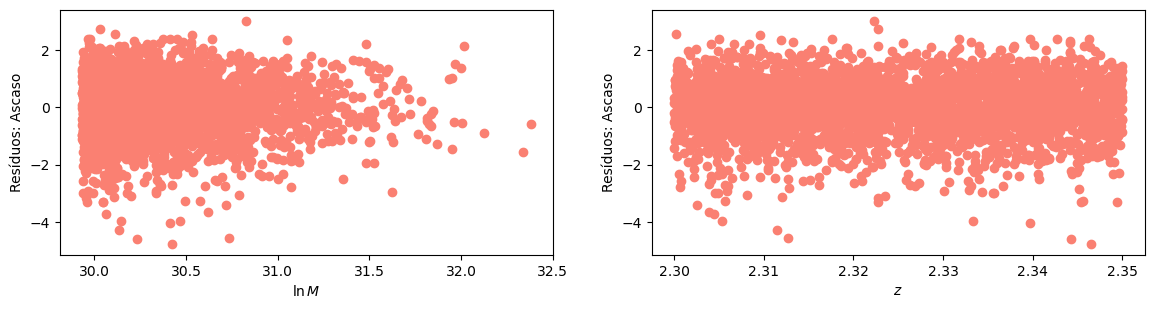

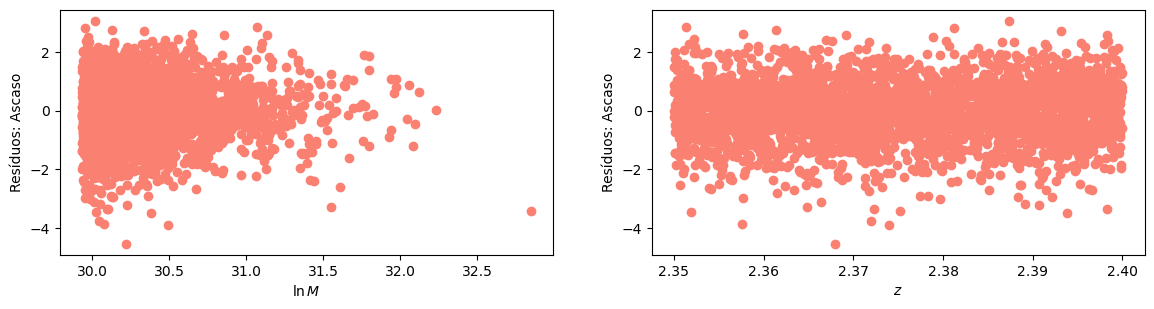

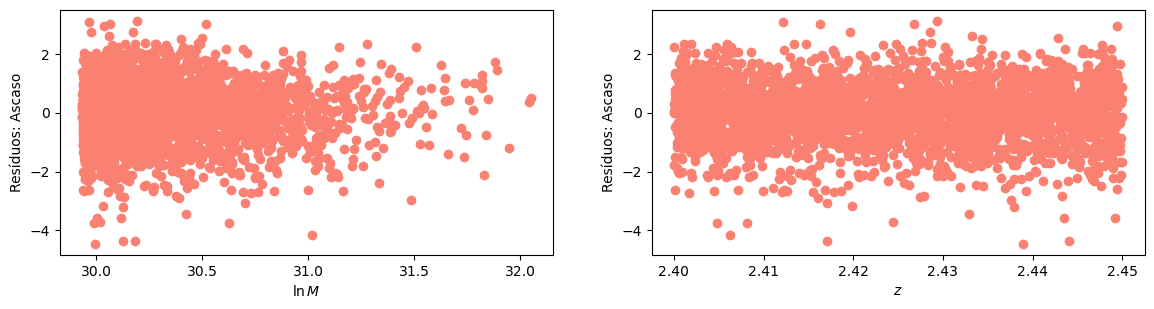

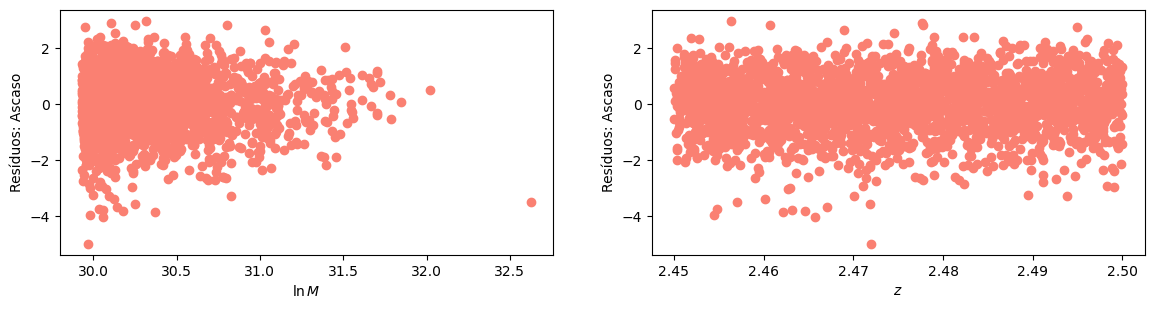

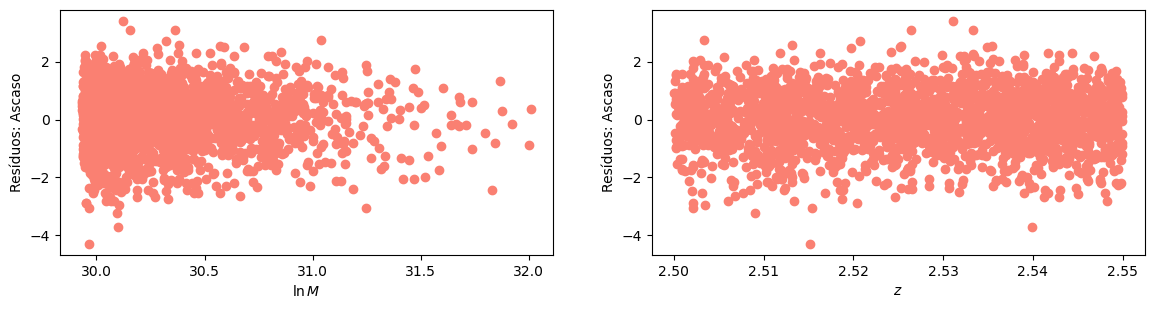

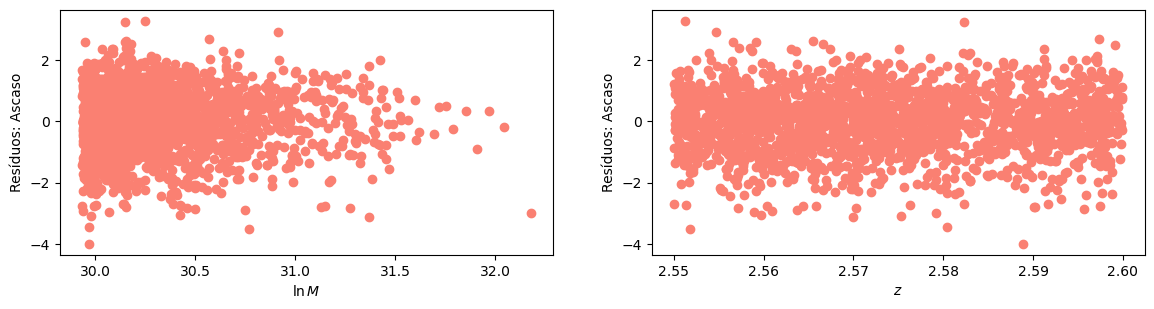

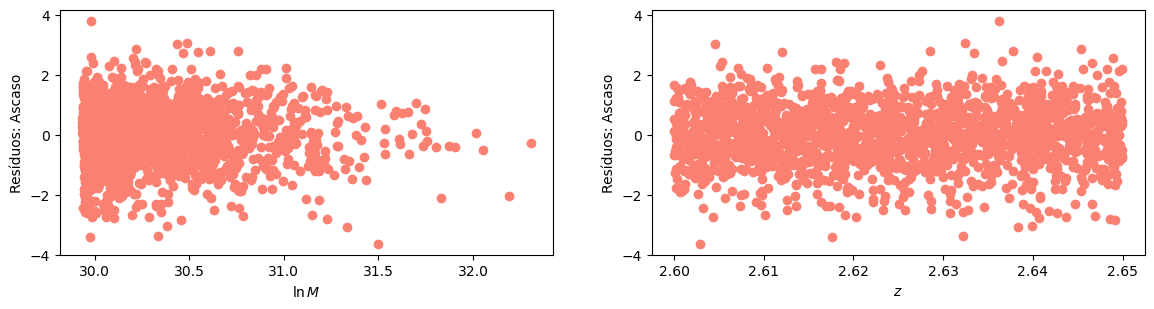

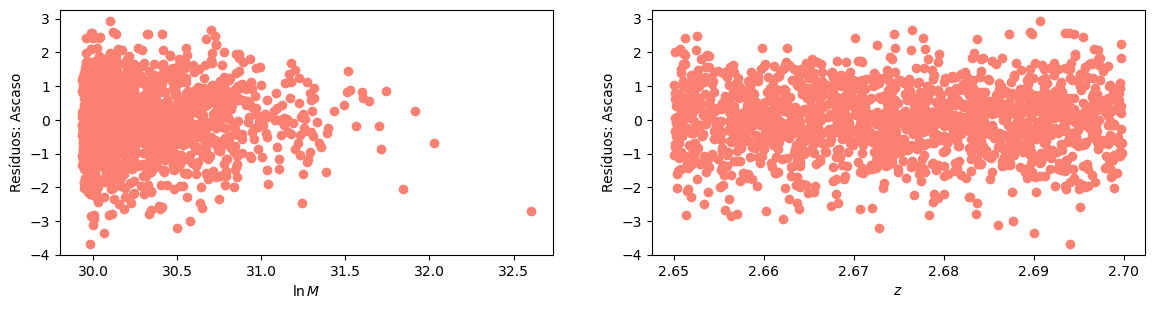

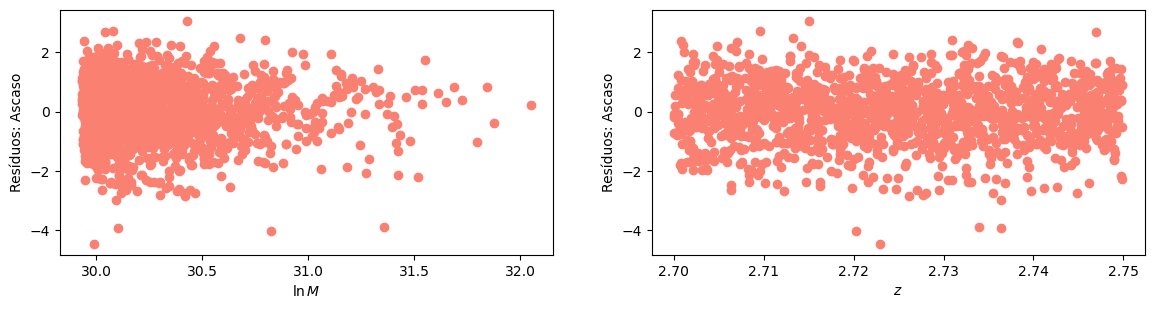

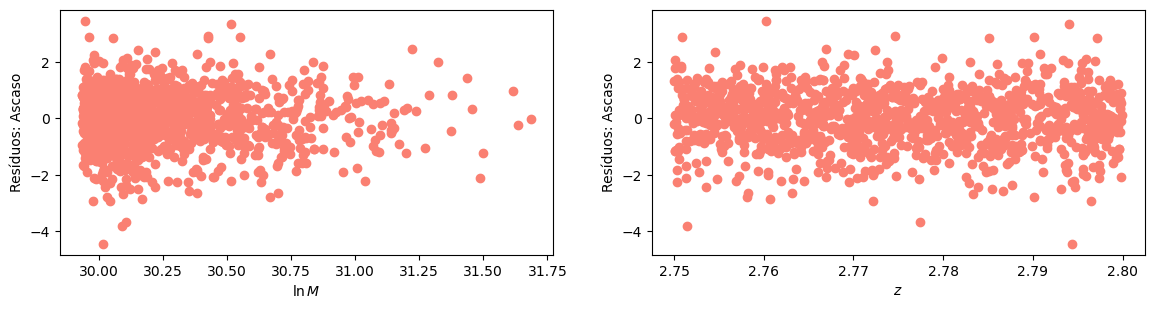

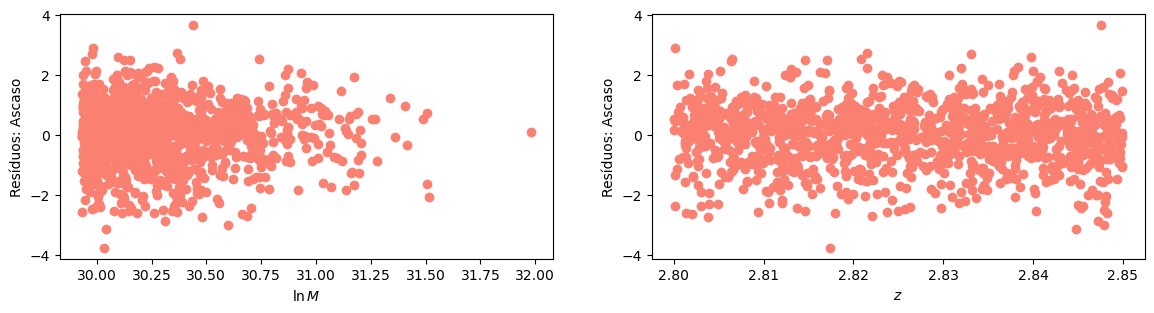

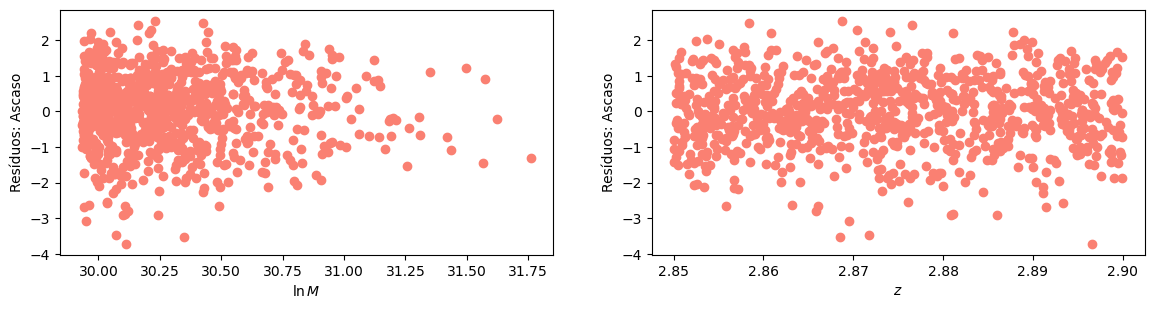

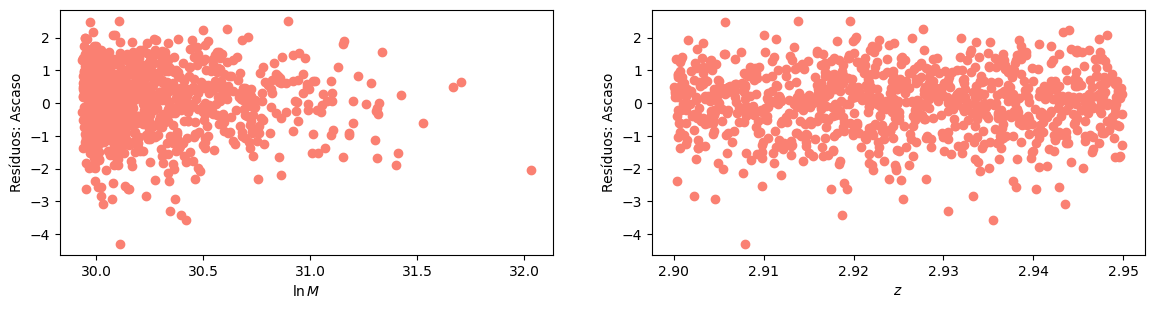

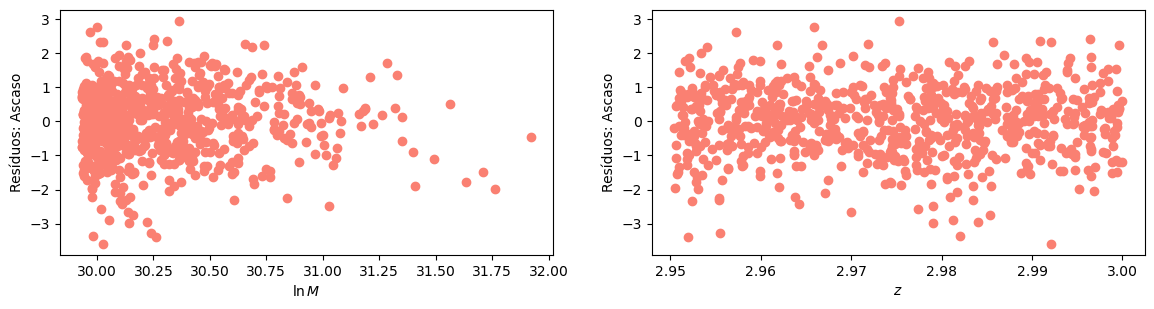

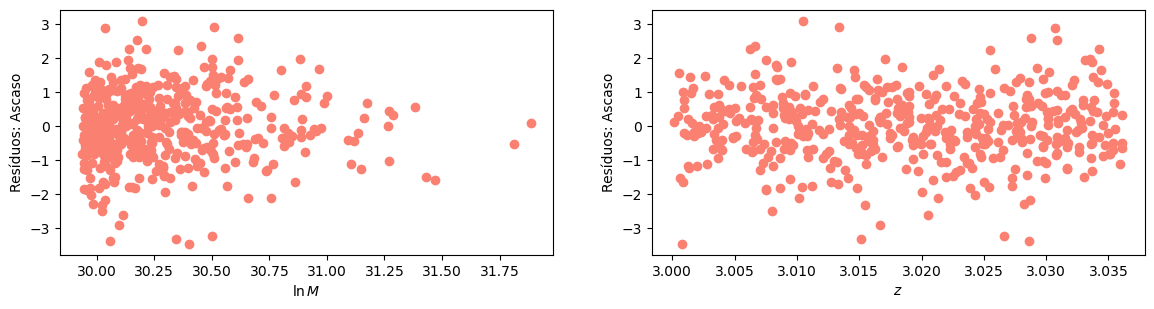

In [4]:
for i, j, k, l, m, n in fit_results_ascaso:
    fig = plt.figure(figsize=(14,7))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)

    ax1.scatter(l, i, c="salmon")
    ax1.set_xlabel("$\ln M$")
    ax1.set_ylabel("Resíduos: Ascaso")

    ax2.scatter(k, i, c="salmon")
    ax2.set_xlabel("$z$")
    ax2.set_ylabel("Resíduos: Ascaso")
    


In [5]:
fit_results_ascaso = []
fit_results_ext = []

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

lnM_0 = min(lnM)
lnM_1 = min(lnM) + 0.5

#nbins = int((max(z) - min(z)) / 0.05)

for i in range(11):
    
    dt_halos = Table(DC2_halos_m200c[1].data)
    catalog_cut = np.logical_and (np.log(dt_halos["m200c"]) > lnM_0, np.log(dt_halos["m200c"]) < lnM_1)
    dt_halos = dt_halos[catalog_cut]
    lnM_0 = lnM_0 + 0.5
    lnM_1 = lnM_1 + 0.5
    
    rmdata = create_richness_mass_calib(dt_halos)
    
    use_ascaso = False

    ascaso = Nc.ClusterMassAscaso()

    ascaso.param_set_by_name("mup0", 4.45393539397061)
    ascaso.param_set_by_name("mup1", 0.688627943224023)
    ascaso.param_set_by_name("mup2", 1.23735536845047)
    ascaso.param_set_by_name("sigmap0", 0.227197277810533)
    ascaso.param_set_by_name("sigmap1", -0.0514034833229222)
    ascaso.param_set_by_name("sigmap2", -0.125446104089159)
    ascaso.param_set_by_name("cut", 1e15)

    
    ascaso.param_set_ftype(0, Ncm.ParamType.FREE)
    ascaso.param_set_ftype(1, Ncm.ParamType.FREE)
    ascaso.param_set_ftype(2, Ncm.ParamType.FREE)
    ascaso.param_set_ftype(3, Ncm.ParamType.FREE)
    ascaso.param_set_ftype(4, Ncm.ParamType.FREE)
    ascaso.param_set_ftype(5, Ncm.ParamType.FREE)
    ascaso.param_set_ftype(6, Ncm.ParamType.FIXED)

    lnrich_ext = Nc.ClusterMassLnrichExt()
    lnrich_ext.param_set_by_name("mu", 4.60456407051582)
    lnrich_ext.param_set_by_name("muM1", 0.872079943089853)
    lnrich_ext.param_set_by_name("muZ1", 1.77432682440775)
    lnrich_ext.param_set_by_name("muM2", 0.0417736274804596)
    lnrich_ext.param_set_by_name("muZ2", -0.140721577418961)
    lnrich_ext.param_set_by_name("muMZ", 0.142254333837774)

    lnrich_ext.param_set_by_name("sigma0", 0.288099083637692)
    lnrich_ext.param_set_by_name("sigmaM1", 0.01665425603827)
    lnrich_ext.param_set_by_name("sigmaZ1", -0.0170544925340452)
    lnrich_ext.param_set_by_name("sigmaM2", 0.0151710348889877)
    lnrich_ext.param_set_by_name("sigmaZ2", 0.00841242091702829)
    lnrich_ext.param_set_by_name("sigmaMZ", 0.0375086602261856)

    lnrich_ext.param_set_by_name("cut", 1e15)
    lnrich_ext.param_set_by_name("cutM1", 0)
    lnrich_ext.param_set_by_name("cutZ1", 0)

    
    lnrich_ext.param_set_ftype(0, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(1, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(2, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(3, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(4, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(5, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(6, Ncm.ParamType.FREE)

    lnrich_ext.param_set_ftype(7, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(8, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(9, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(10, Ncm.ParamType.FREE)
    lnrich_ext.param_set_ftype(11, Ncm.ParamType.FREE)

    lnrich_ext.param_set_ftype(12, Ncm.ParamType.FIXED)
    lnrich_ext.param_set_ftype(13, Ncm.ParamType.FIXED)
    lnrich_ext.param_set_ftype(14, Ncm.ParamType.FIXED)

    mset_ascaso = Ncm.MSet()
    mset_ascaso.set(ascaso)

    mset_ext = Ncm.MSet()
    mset_ext.set(lnrich_ext)
    
    dset = Ncm.Dataset.new()
    dset.append_data(rmdata)

    lh = Ncm.Likelihood.new(dset)

    # mset_ascaso.param_set_all_ftype(Ncm.ParamType.FIXED)
    # mset_ext.param_set_all_ftype(Ncm.ParamType.FIXED)

    fit_ascaso = Ncm.Fit.new(
        Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ascaso, Ncm.FitGradType.NUMDIFF_CENTRAL)

    fit_ext = Ncm.Fit.new(
        Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ext, Ncm.FitGradType.NUMDIFF_CENTRAL)

    fit_ascaso.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
    fit_ext.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
    
    lnM = np.log(dt_halos["m200c"])  # ln(mass)
    z = dt_halos["redshift_true"]  # redshift
    lnR = np.log(dt_halos["richness"])  # ln(richness)
    
    res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnr_cut_ascaso, lnR_ascaso  = compute_res(ascaso)

    res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnr_cut_ext, lnR_ext  = compute_res(lnrich_ext)
    
    fit_results_ascaso.append((res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnr_cut_ascaso, lnR_ascaso))
    fit_results_ext.append((res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnr_cut_ext, lnR_ext))


AttributeError: type object 'Fit' has no attribute 'new'

In [ ]:
# Residuals

for i, j, k, l, m, n in fit_results_ext:
    fig = plt.figure(figsize=(14,7))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)

    ax1.scatter(l, i, c="skyblue")
    ax1.set_xlabel("$\ln M$")
    ax1.set_ylabel("Resíduos: Extendida")

    ax2.scatter(k, i, c="skyblue")
    ax2.set_xlabel("$z$")
    ax2.set_ylabel("Residuals Extendida")
    

In [ ]:
for i, j, k, l, m, n in fit_results_ascaso:
    fig = plt.figure(figsize=(14,7))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)

    ax1.scatter(l, i, c="salmon")
    ax1.set_xlabel("$\ln M$")
    ax1.set_ylabel("Resíduos: Ascaso")

    ax2.scatter(k, i, c="salmon")
    ax2.set_xlabel("$z$")
    ax2.set_ylabel("Resíduos: Ascaso")
   

In [ ]:
res_ext_m = [i for i, j, k, l, m, n in fit_results_ext]
res_ascaso_m = [i for i, j, k, l, m, n in fit_results_ascaso]
    
fig, axs = plt.subplots(nrows=3, ncols=5, figsize = (12,5))

for res_ext, ax in zip(res_ext_m, axs.flat):
    ax.hist(res_ext, bins=40, density=True)
    ax.tick_params(axis='x', labelrotation = 45)
fig.tight_layout()

plt.show()


In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize = (12,5))

for res_ext, ax in zip(res_ascaso_m, axs.flat):
    ax.hist(res_ext, bins=40, density=True)
    ax.tick_params(axis='x', labelrotation = 45)
fig.tight_layout()

plt.show()


In [ ]:
for res in res_ascaso_m:
    print(stats.kstest(res, stats.norm.cdf))

In [ ]:
for res in res_ext_m:
    print(stats.kstest(res, stats.norm.cdf))